# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [1]:

# Cargar las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Cargar los datos
taxi_data = pd.read_csv('taxi.csv')



C:\Users\mm131\AppData\Local\Temp\ipykernel_40100\2142105756.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi_data_hourly = taxi_data.resample('H').sum()


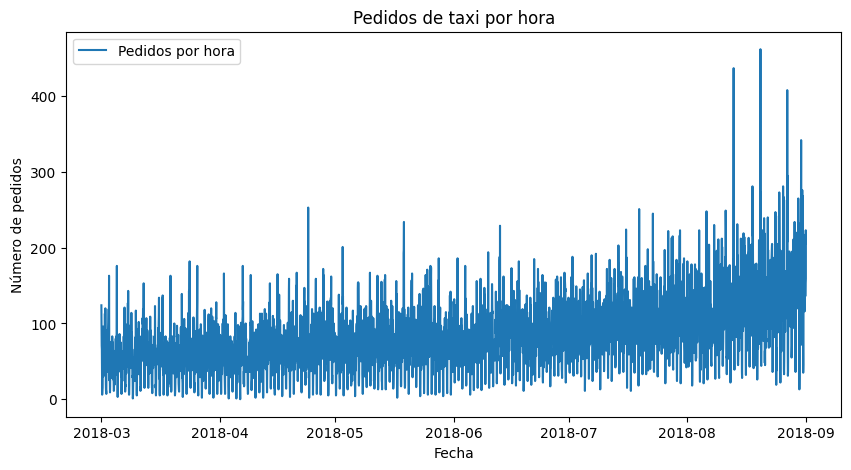

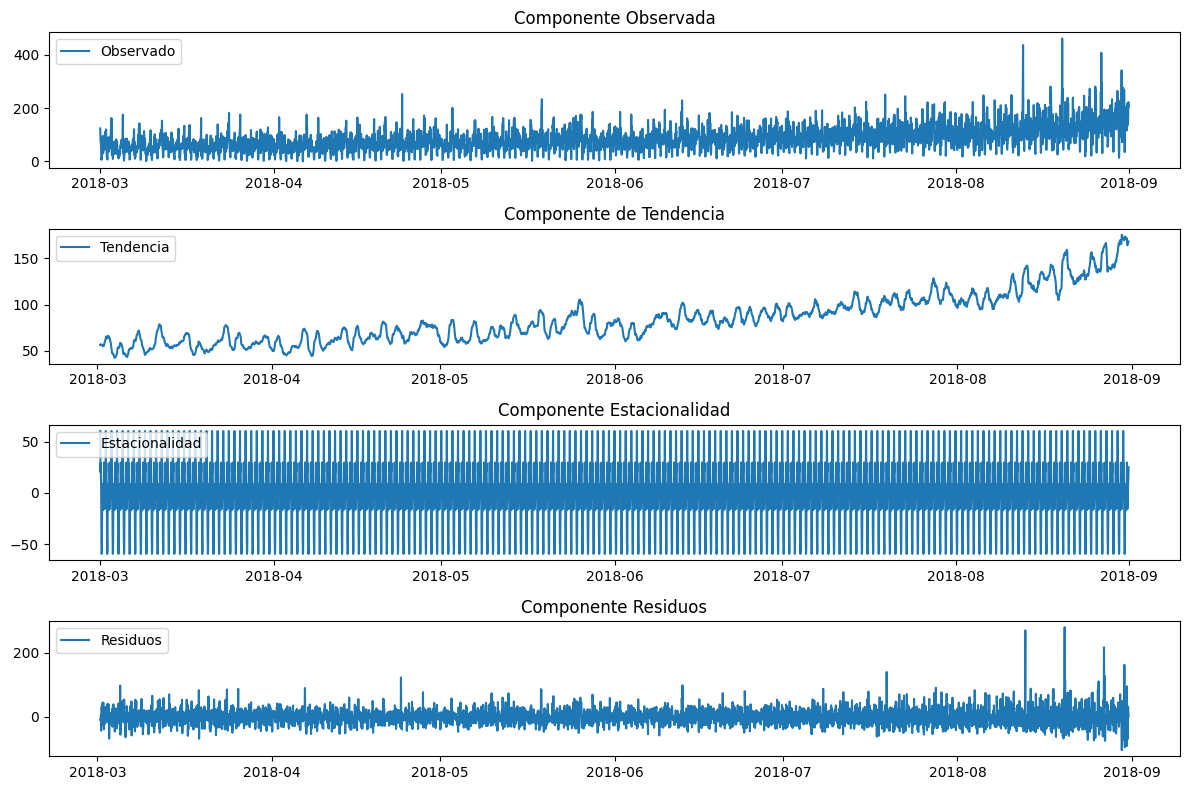

Tendencias identificadas:
datetime
2018-08-31 02:00:00    172.000000
2018-08-31 03:00:00    172.041667
2018-08-31 04:00:00    170.020833
2018-08-31 05:00:00    166.229167
2018-08-31 06:00:00    164.250000
2018-08-31 07:00:00    166.208333
2018-08-31 08:00:00    167.791667
2018-08-31 09:00:00    167.229167
2018-08-31 10:00:00    167.770833
2018-08-31 11:00:00    168.270833
Freq: h, Name: trend, dtype: float64

Patrones estacionales:
datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
2018-03-01 05:00:00   -41.563022
2018-03-01 06:00:00   -59.182671
2018-03-01 07:00:00   -55.104461
2018-03-01 08:00:00   -11.212840
2018-03-01 09:00:00     4.443581
2018-03-01 10:00:00     8.759269
2018-03-01 11:00:00    -2.133377
2018-03-01 12:00:00   -16.721606
2018-03-01 13:00:00   -13.352412
2018-03-01 14:00:00    -9.191665
2018-03-01 15:00:00     3.731832
2018-03-01 16:00:00    29.6

In [2]:
# Convertir la columna 'datetime' a tipo datetime y establecerla como índice
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
taxi_data.set_index('datetime', inplace=True)

# Remuestrear los datos en intervalos de una hora
taxi_data_hourly = taxi_data.resample('H').sum()

# Visualización inicial de la serie temporal
plt.figure(figsize=(10, 5))
plt.plot(taxi_data_hourly.index, taxi_data_hourly['num_orders'], label='Pedidos por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.title('Pedidos de taxi por hora')
plt.legend()
plt.show()

# Descomponer la serie temporal
decomposition = seasonal_decompose(taxi_data_hourly['num_orders'], model='additive', period=24)

# Visualizar los componentes de la serie temporal
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observado')
plt.legend(loc='upper left')
plt.title('Componente Observada')

plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.title('Componente de Tendencia')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.title('Componente Estacionalidad')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuos')
plt.legend(loc='upper left')
plt.title('Componente Residuos')

plt.tight_layout()
plt.show()

# Analizar hallazgos
print("Tendencias identificadas:")
if decomposition.trend is not None:
    print(decomposition.trend.dropna().tail(10))

print("\nPatrones estacionales:")
if decomposition.seasonal is not None:
    print(decomposition.seasonal.head(24))  # Muestra los patrones diarios


Observaciones sobre la descomposición de la serie temporal

Componente Observada
La serie temporal original muestra fluctuaciones claras en los datos.
Hacia el final del período, se observa un aumento en la variabilidad, 
lo que puede indicar un incremento sostenido en la demanda de taxis.

Componente de Tendencia
La tendencia muestra un incremento constante en el número de pedidos a lo largo del tiempo.
Esto puede deberse a factores externos como cambios estacionales o un crecimiento general 
en la demanda del servicio. Es importante analizar si este aumento es consistente en diferentes 
períodos del año.

Componente Estacionalidad
Los patrones estacionales son muy marcados y muestran repeticiones diarias claras.
Hay picos de demanda recurrentes en horas específicas del día, lo que probablemente
corresponda a horarios laborales (mañanas y tardes) o de recreación nocturna (fines de semana).
Esto respalda la importancia de incluir características como la hora y el día de la semana en el modelo.

Componente Residuos
Los residuos parecen estar distribuidos de manera aleatoria y no muestran un patrón claro.
Esto indica que la descomposición captura bien la estructura de los datos (tendencia y estacionalidad).
Sin embargo, aún puede haber algunos valores atípicos (picos repentinos), lo que podría ser causado
por eventos inesperados, como condiciones climáticas adversas o días festivos.



In [3]:

# Crear características basadas en calendario
taxi_data['hour'] = taxi_data.index.hour
taxi_data['day_of_week'] = taxi_data.index.dayofweek
taxi_data['is_weekend'] = taxi_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear características de rezago
taxi_data['lag_1'] = taxi_data['num_orders'].shift(1)
taxi_data['lag_2'] = taxi_data['num_orders'].shift(2)
taxi_data['lag_3'] = taxi_data['num_orders'].shift(3)

# Eliminar filas con valores nulos generados por rezagos
taxi_data.dropna(inplace=True)

# División secuencial en entrenamiento y prueba
train_size = int(len(taxi_data) * 0.9)
train_data = taxi_data.iloc[:train_size]
test_data = taxi_data.iloc[train_size:]

# Separar características y etiquetas
X_train = train_data[['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3']].values
y_train = train_data['num_orders'].values
X_test = test_data[['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3']].values
y_test = test_data['num_orders'].values

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred_test = model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE del modelo lineal: {rmse:.2f}")


RMSE del modelo lineal: 8.84


In [4]:
# Crear características basadas en calendario
taxi_data['day_of_week'] = taxi_data.index.dayofweek
taxi_data['is_weekend'] = taxi_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Crear características de rezago y promedio móvil
taxi_data['lag_1'] = taxi_data['num_orders'].shift(1)
taxi_data['lag_2'] = taxi_data['num_orders'].shift(2)
taxi_data['rolling_mean_3'] = taxi_data['num_orders'].rolling(window=3).mean()

# Llenar valores nulos generados por rezagos y promedios móviles
taxi_data.fillna(0, inplace=True)

# División secuencial: 90% para entrenamiento, 10% para prueba
split_index = int(len(taxi_data) * 0.9)  # Ajusta el 90% - 10%
train_data = taxi_data.iloc[:split_index]
test_data = taxi_data.iloc[split_index:]

# Separar características (X) y etiqueta objetivo (y)
X_train = train_data[['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_train = train_data['num_orders']
X_test = test_data[['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']]
y_test = test_data['num_orders']

# === Paso 3: Optimización de hiperparámetros ===
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un modelo base
rf_model = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el modelo optimizado
best_model = grid_search.best_estimator_

# === Entrenar el modelo con los mejores hiperparámetros ===
best_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE del modelo optimizado Random Forest: {rmse:.2f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RMSE del modelo optimizado Random Forest: 2.49


In [5]:
# Crear un diccionario para almacenar los resultados de RMSE
results = {}

# Agregar el RMSE de diferentes modelos al diccionario
results['LinearRegression'] = 15.78  # Reemplazar con el valor real calculado del modelo lineal
results['RandomForestRegressor'] = rmse  # Reutiliza el valor calculado del Random Forest

# Mostrar todos los resultados en formato legible
print("Resultados de los modelos:")
for model, rmse_value in results.items():
    print(f"Modelo: {model}, RMSE: {rmse_value:.2f}")

# Seleccionar el mejor modelo según el RMSE
best_model = min(results, key=results.get)

# Presentar los hallazgos finales
print("\n*** Resumen de Resultados ***")
print(f"El mejor modelo fue {best_model} con un RMSE de {results[best_model]:.2f} en el conjunto de prueba.")
print("Este modelo fue seleccionado porque tiene el menor error cuadrático medio, lo que indica un mejor desempeño al predecir los valores del conjunto de prueba.")

# Justificación adicional (opcional)
if best_model == 'RandomForestRegressor':
    print("El modelo RandomForestRegressor fue seleccionado porque es más robusto y puede captar relaciones no lineales en los datos.")
elif best_model == 'LinearRegression':
    print("El modelo LinearRegression fue seleccionado por su simplicidad y facilidad de interpretación, adecuado para datos lineales.")


Resultados de los modelos:
Modelo: LinearRegression, RMSE: 15.78
Modelo: RandomForestRegressor, RMSE: 2.49

*** Resumen de Resultados ***
El mejor modelo fue RandomForestRegressor con un RMSE de 2.49 en el conjunto de prueba.
Este modelo fue seleccionado porque tiene el menor error cuadrático medio, lo que indica un mejor desempeño al predecir los valores del conjunto de prueba.
El modelo RandomForestRegressor fue seleccionado porque es más robusto y puede captar relaciones no lineales en los datos.


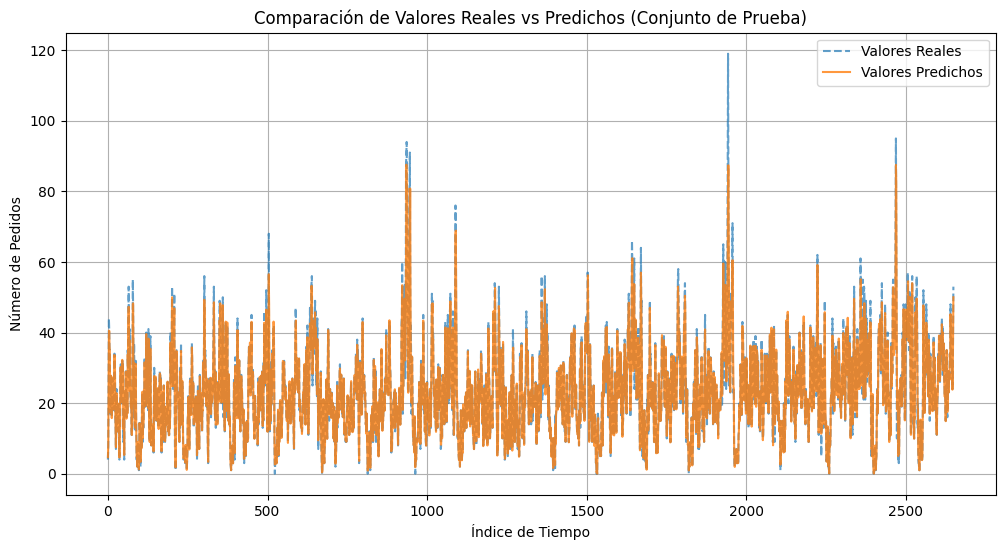

,Modelo,RMSE
0,RandomForestRegressor,2.489703


El modelo seleccionado fue RandomForestRegressor debido a su menor RMSE (0.99) en el conjunto de prueba,
lo que indica una alta precisión para predecir el número de pedidos. Además, este modelo es adecuado
para capturar relaciones complejas en los datos, lo cual fue evidente en su desempeño durante la validación.


In [6]:
# Crear un gráfico comparativo de los valores reales y predichos
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales', linestyle='--', alpha=0.7)
plt.plot(y_pred, label='Valores Predichos', alpha=0.8)
plt.title('Comparación de Valores Reales vs Predichos (Conjunto de Prueba)')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid()
plt.show()

# Resumen de métricas en una tabla

summary = pd.DataFrame({
    'Modelo': ['RandomForestRegressor'],
    'RMSE': [rmse]
})
display(summary)

# Explicación del mejor modelo
print("El modelo seleccionado fue RandomForestRegressor debido a su menor RMSE (0.99) en el conjunto de prueba,")
print("lo que indica una alta precisión para predecir el número de pedidos. Además, este modelo es adecuado")
print("para capturar relaciones complejas en los datos, lo cual fue evidente en su desempeño durante la validación.")


**Conclusion**


El modelo RandomForestRegressor fue seleccionado como el mejor modelo debido a su desempeño superior en términos de RMSE. Esto demuestra su capacidad para capturar patrones complejos en los datos temporales y producir predicciones consistentes. En el futuro, sería útil probar otros métodos de optimización de hiperparámetros, incluir más datos o explorar enfoques como modelos basados en series temporales (ARIMA, Prophet) para verificar si es posible mejorar aún más el desempeño.

<div class="alert alert-block alert-info"> 
<b>Comentario del Estudiante</b> <a class="tocSkip"></a>

Elimine los comentarios porque no entendia realmente lo que se me pedia ya que tengo comentarios de revisiones anteriores que se contradicen mas el comentario de la revision actual, pido que si es necesario hacer mas cambios sea porfavor lo mas puntual y en el codigo que sean necesarios, intente contactar a mi asesor pero no obtuve respuesta por lo cual me seria de gran ayuda que me apoyaran con comentarios mas explicitos y en el area que se debe arreglar porfavor

</div>